## Frisch-Waugh-Lowell Theorem

Suppose we have a regression equation defined as follows.

$y \sim \beta_1 x_1 + \beta_2 x_2 + \epsilon$

The [Frisch-Waugh-Lowell Theorem](https://en.wikipedia.org/wiki/Frisch%E2%80%93Waugh%E2%80%93Lovell_theorem) (FWLT) states that $\beta_1$ can be estimated equivalently by the following estimators.

- $y \sim \beta_1 x_1 + \beta_2 x_2$
- $y \sim \beta_1 r_1$ where $m_1 = x_1 \sim x_2$ and $r_1 = x_1 - m_1(x_2)$
- $r_2 \sim \beta_1 r_1$ where $m_2 = y \sim x_2$ and $r_2 = y - m_2(x_2)$

In plain words, corresponding to each of the estimators above:

- $\beta_1$ is estimated as usual from a regression model
- $\beta_1$ is estimated from regression of $y$ on the residuals of $x_1 \sim x_2$
- $\beta_1$ is estimated from regressing the residuals of $y \sim x_2$ on the residuals of $x_1 \sim x_2$

The approach of the second estimator is called `partialling-out`, `orthogonalization` or `residualization`. Partialling-out removes information on $x_1$ that is explained by $x_2$; or, equivalently, partialling-out keeps information about $x_1$ that is not explained by $x_2$. 

Let's verify FWLT.

## Load data

We will load the [diabetes data](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset).

In [22]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True, as_frame=True)
X.shape, y.shape

((442, 10), (442,))

Since we will focus on `bmi` (body mass index), `age` and disease progression (target/y), let's visualize their distributions.

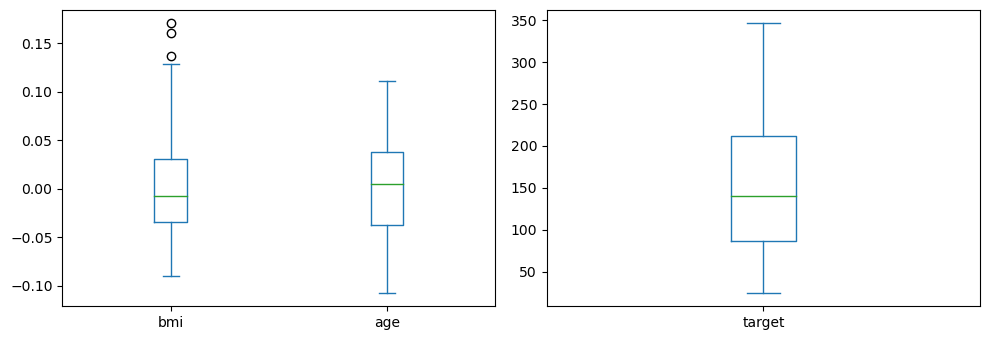

In [112]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))

X[['bmi', 'age']].plot(kind='box', ax=ax[0])
y.plot(kind='box')

fig.tight_layout()

Below is a heatmap of the pairwise correlations between these variables.

<Axes: >

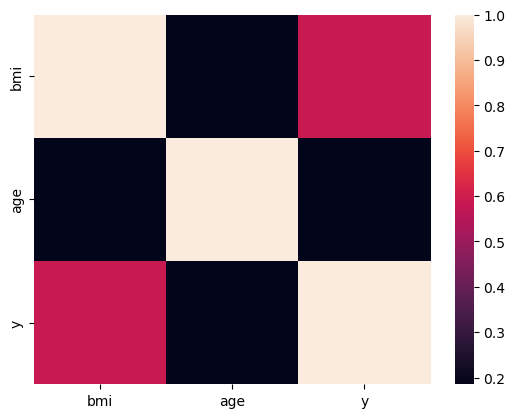

In [116]:
import seaborn as sns

sns.heatmap(X.assign(y=y)[['bmi', 'age', 'y']].corr())

## Normal estimation

Let's try to estimate the parameters for the following equation.

$y \sim \beta_1 \mathrm{bmi} + \beta_2 \mathrm{age}$

In [117]:
from sklearn.linear_model import LinearRegression

m = LinearRegression(n_jobs=-1)
m.fit(X[['bmi', 'age']], y)
m.intercept_, m.coef_

(152.13348416289614, array([924.81645876, 133.01372901]))

As you can see, for every unit increase in bmi, there is a about a 925 unit increase in y.

The mean absolute error `MAE` and root mean squared errors `RMSE` are shown below.

In [124]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = m.predict(X[['bmi', 'age']])
mean_absolute_error(y, y_pred), mean_squared_error(y, y_pred, squared=False)

(51.96753230222509, 62.06286486063625)

Without validation, the linear model seems to be a nearly perfect one based on the plots below.

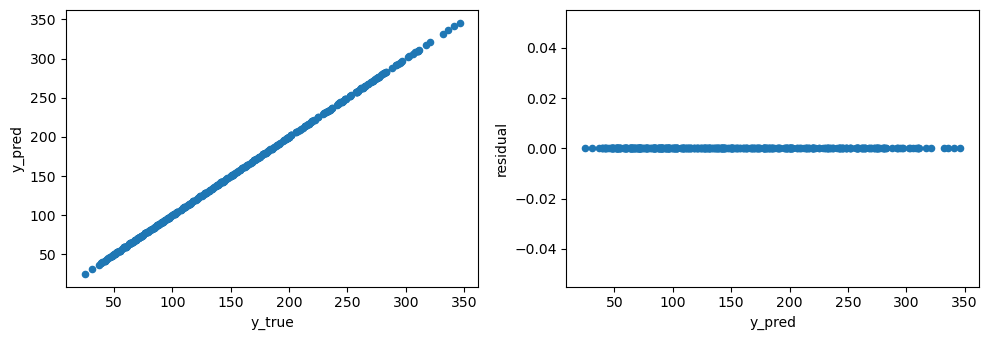

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))

pd.DataFrame({'y_true': y, 'y_pred': y}) \
    .sort_values(['y_true']) \
    .plot(kind='scatter', x='y_true', y='y_pred', ax=ax[0])

pd.DataFrame({'y_true': y, 'y_pred': y}) \
    .assign(residual=lambda d: d['y_true'] - d['y_pred']) \
    .plot(kind='scatter', x='y_pred', y='residual', ax=ax[1])

fig.tight_layout()

Finally, let's look at some partial dependence plots. Individually and together, an increase of bmi and age tends to increase disease progression.

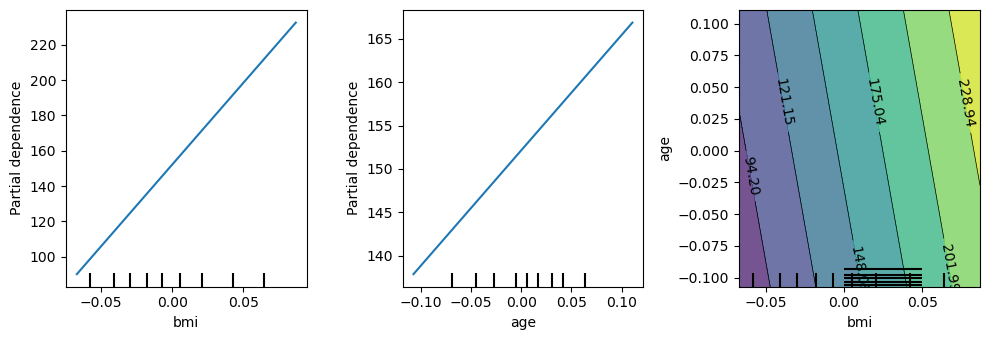

In [137]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(1, 3, figsize=(10, 3.5))

PartialDependenceDisplay.from_estimator(m, X[['bmi', 'age']], ['bmi'], ax=ax[0])
PartialDependenceDisplay.from_estimator(m, X[['bmi', 'age']], ['age'], ax=ax[1])
PartialDependenceDisplay.from_estimator(m, X[['bmi', 'age']], [('bmi', 'age')], ax=ax[2])

fig.tight_layout()

## Partialling-out, orthogonalization, residualization

Back, to FWLT. Denote the following.

- $f = \mathrm{bmi} \sim \mathrm{age}$ ($f$ is the regression of bmi on age)
- $r = bmi - f(\mathrm{age})$ ($r$ is the residual)
- $g = y \sim r$ ($g$ is the regression of $y$ on the residual)

The coefficient associated with $r$ in the last regression should have the same value as with the full regression.

In [138]:
f = LinearRegression(n_jobs=-1)
f.fit(X[['age']], X['bmi'])

r = X['bmi'] - f.predict(X[['age']])

In [139]:
g = LinearRegression(n_jobs=-1)
g.fit(r.to_frame(), y)
g.coef_

array([924.81645876])

The last way to estimate $\beta_1$ is as follows.

- $h = y \sim \mathrm{age}$ ($h$ is the regression of $y$ on age)
- $s = y - h(\mathrm{age})$ ($s$ is the residual)
- $i = s \sim r$ ($i$ is the regression of $y$ on the residual)

Again, the coefficient associated with $r$ in the last regression is the same value as with the full regression.

In [140]:
h = LinearRegression(n_jobs=-1)
h.fit(X[['age']], y)

s = y - h.predict(X[['age']])

In [141]:
i = LinearRegression(n_jobs=-1)
i.fit(r.to_frame(), s)
i.coef_

array([924.81645876])

Out of curiousity, let's look at a scatter plot of the residuals $s$ and $r$.

<Axes: xlabel='r', ylabel='s'>

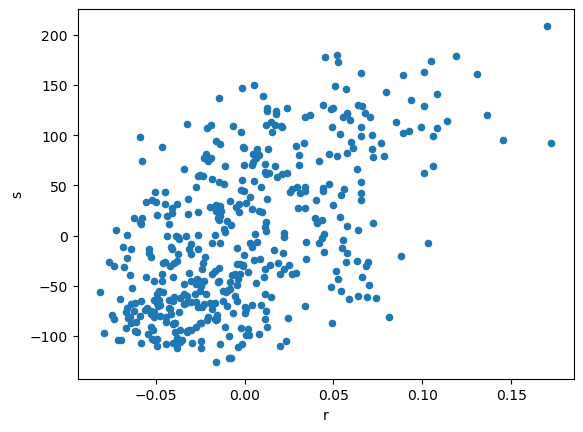

In [45]:
pd.DataFrame({'r': r, 's': s}) \
    .plot(kind='scatter', x='r', y='s')

The term partialling out represents the removal of levels and trend (the linear fit) from the residuals. The term orthogonalization represents the visual interpretation of what's happening; we are reprojecting the residuals onto an axis orthogonal to the variable of interest. The residuals hold all information about the dependent variable that is not in the indepent variable(s). Residualization effectively refers to the use of residuals in the estimation.

## Multiple controls

FWLT extends to multiple controls. Denote the following.

- $m = y \sim \mathrm{bmi} + \mathrm{age} + \mathrm{sex} + \mathrm{bp} + \mathrm{s1} + \mathrm{s2} + \mathrm{s3} + \mathrm{s4} + \mathrm{s5} + \mathrm{s6}$
- $m_1 = \mathrm{bmi} \sim \mathrm{age} + \mathrm{sex} + \mathrm{bp} + \mathrm{s1} + \mathrm{s2} + \mathrm{s3} + \mathrm{s4} + \mathrm{s5} + \mathrm{s6}$
- $m_2 = y \sim \mathrm{age} + \mathrm{sex} + \mathrm{bp} + \mathrm{s1} + \mathrm{s2} + \mathrm{s3} + \mathrm{s4} + \mathrm{s5} + \mathrm{s6}$
- $r_1 = bmi - m_1(\mathrm{age}, \mathrm{sex}, \mathrm{bp}, \mathrm{s1}, \mathrm{s2}, \mathrm{s3}, \mathrm{s4}, \mathrm{s5}, \mathrm{s6})$
- $r_2 = y - m_2(\mathrm{age}, \mathrm{sex}, \mathrm{bp}, \mathrm{s1}, \mathrm{s2}, \mathrm{s3}, \mathrm{s4}, \mathrm{s5}, \mathrm{s6})$
- $m_3 = r_2 \sim r_1$

The coefficient associated with bmi in $m$ is equivalent to the coefficient associated with $r_1$ in $m_3$.

In [142]:
m1 = LinearRegression()
m2 = LinearRegression()
m3 = LinearRegression()

m1.fit(X.drop(columns=['bmi']), X['bmi'])
m2.fit(X.drop(columns=['bmi']), y)

r1 = X['bmi'] - m1.predict(X.drop(columns=['bmi']))
r2 = y - m2.predict(X.drop(columns=['bmi']))

m3.fit(r1.to_frame(), r2)
m3.coef_

array([519.84592005])

In [143]:
m = LinearRegression()
m.fit(X, y)
pd.Series(m.coef_, X.columns)

age    -10.009866
sex   -239.815644
bmi    519.845920
bp     324.384646
s1    -792.175639
s2     476.739021
s3     101.043268
s4     177.063238
s5     751.273700
s6      67.626692
dtype: float64

## Non-linear estimators

We do not have to use linear estimators for $m_1$ and $m_2$; below, we use random forest models instead. The final estimation from the non-linear estimators is lower than the one from linear estimators.

In [144]:
from sklearn.ensemble import RandomForestRegressor

m1 = RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=10)
m2 = RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=10)
m3 = LinearRegression()

m1.fit(X.drop(columns=['bmi']), X['bmi'])
m2.fit(X.drop(columns=['bmi']), y)

r1 = X['bmi'] - m1.predict(X.drop(columns=['bmi']))
r2 = y - m2.predict(X.drop(columns=['bmi']))

m3.fit(r1.to_frame(), r2)
m3.coef_

array([508.34043333])

## Sample-splitting

When there is overfitting with $m_1$ and $m_2$, the estimation will be biased. To combat biased estimation, `sample-splitting` is applied. In sample-splitting, for a large number of times,

- we split the data into training and testing,
- learn the estimators $m_1$ and $m_2$ from the training data,
- generate the residuals off the testing data, and
- regress the residuals to find the estimation (coefficient).

The sample splitting estimations are then averaged to produce the final estimation. Below, we do this for all variables.

In [255]:
from sklearn.model_selection import train_test_split

def get_estimate(d_col='bmi', random_state=37):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, shuffle=True, test_size=0.5, random_state=random_state)
    
    X_tr, d_tr = X_tr.drop(columns=[d_col]), X_tr[d_col]
    X_te, d_te = X_te.drop(columns=[d_col]), X_te[d_col]
    
    m1 = RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=10)
    m2 = RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=10)
    m3 = LinearRegression()

    m1.fit(X_tr, d_tr)
    m2.fit(X_tr, y_tr)

    r1 = d_te - m1.predict(X_te)
    r2 = y_te - m2.predict(X_te)

    m3.fit(r1.to_frame(), r2)
    
    return m3.coef_[0]

def estimate(d_col='bmi', max_iter=200):
    estimates = [get_estimate(d_col, i) for i in range(max_iter)]
    return {
        'variable': d_col,
        'estimate': np.mean(estimates),
        'std': np.std(estimates)
    }

pd.DataFrame([estimate(c) for c in X.columns])

,variable,estimate,std
0,age,2.107160,69.651271
1,sex,-205.918395,73.585760
2,bmi,495.455222,81.473690
3,bp,265.241904,71.549371
4,s1,-134.198358,313.943890
5,s2,-52.306987,286.652365
6,s3,-236.446231,163.779218
7,s4,97.210133,257.698259
8,s5,515.953055,113.054241
9,s6,83.226874,75.599235


## Sample-splitting and cross-fitting

We can combine sample-splitting with cross-fitting to provide an unbiased estimate. In cross-fitting, we split the data into two folds, $a$ and $b$. We train a model on $a$ and estimate the coefficient on $b$, we also train a model on $b$ and estimate the coefficient on $a$; the average of these two coefficients is the final estimation.

In [257]:
def cross_fit(X_tr, d_tr, y_tr, X_te, d_te, y_te):
    m1 = RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=10)
    m2 = RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=10)
    m3 = LinearRegression()

    m1.fit(X_tr, d_tr)
    m2.fit(X_tr, y_tr)

    r1 = d_te - m1.predict(X_te)
    r2 = y_te - m2.predict(X_te)

    m3.fit(r1.to_frame(), r2)
    
    return m3.coef_[0]

def split_fit(d_col='bmi', random_state=37):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, shuffle=True, test_size=0.5, random_state=random_state)
    
    X_tr, d_tr = X_tr.drop(columns=[d_col]), X_tr[d_col]
    X_te, d_te = X_te.drop(columns=[d_col]), X_te[d_col]
    
    lhs = cross_fit(X_tr, d_tr, y_tr, X_te, d_te, y_te)
    rhs = cross_fit(X_te, d_te, y_te, X_tr, d_tr, y_tr)
    
    return np.mean([lhs, rhs])

def estimate(d_col='bmi', max_iter=100):
    estimates = [split_fit(d_col, i) for i in range(max_iter)]
    return {
        'variable': d_col,
        'estimate': np.mean(estimates),
        'std': np.std(estimates)
    }

pd.DataFrame([estimate(c) for c in X.columns])

,variable,estimate,std
0,age,6.990086,40.040529
1,sex,-208.788784,44.207837
2,bmi,491.990834,45.080000
3,bp,262.765973,37.226123
4,s1,-110.913374,154.213316
5,s2,-78.543704,126.827543
6,s3,-233.844736,87.138051
7,s4,117.667220,128.956083
8,s5,519.283738,67.865800
9,s6,75.133127,41.054708


## Double machine learning

FWLT has implications for causal inference in terms of estimating average treatment effect (ATE). Denote the following.

- $y$ the outcome variable
- $d$ the treatment variable (the variable that we want to estimate `ATE` for)
- $X$ the set of confounding variables

Then, denote the following models.

- $m_1 = d \sim X$
- $m_2 = y \sim X$

Denote the corresponding residuals to the models.

- $r_1 = d - m_1(X)$
- $r_2 = y - m_2(X)$

Finally, define a linear model as follows.

- $r_2 \sim \beta_1 r_1$

$\beta_1$ is the ATE.

Double machine learning `DML` generalizes the FWLT approach with many benefits. A key benefit is the correcting for regularization and overfitting biases; the former is achieved through orthogonalization (FWLT) and the latter is achieved to sample-splitting and cross-fitting. Let's see how DML estimates ATE for each of the variables.

In [147]:
from doubleml import DoubleMLData
from doubleml import DoubleMLPLR
from sklearn.base import clone

def get_model(d_col):
    np.random.seed(3141)
    data = DoubleMLData(
        X.assign(y=y),
        y_col='y',
        d_cols=d_col,
        x_cols=list(X.columns.drop([d_col]))
    )

    learner = RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=10)
    ml_l = clone(learner)
    ml_m = clone(learner)

    m = DoubleMLPLR(data, ml_l, ml_m, n_folds=5, n_rep=1, score='partialling out', dml_procedure='dml2')
    m.fit(store_models=True)
    
    return m

def get_summary(d_col):
    m = get_model(d_col)
    return m.summary

pd.concat([get_summary(c) for c in X.columns])

,coef,std err,t,P>|t|,2.5 %,97.5 %
age,-8.725229,59.042732,-0.147778,8.825178e-01,-124.446858,106.996400
sex,-198.485390,59.895497,-3.313862,9.201703e-04,-315.878408,-81.092373
bmi,448.273300,75.330901,5.950723,2.669611e-09,300.627447,595.919152
bp,271.593295,64.953301,4.181362,2.897675e-05,144.287163,398.899426
s1,-237.891157,237.396920,-1.002082,3.163040e-01,-703.180571,227.398256
s2,-115.889975,245.066520,-0.472892,6.362903e-01,-596.211528,364.431579
s3,-123.176182,150.923436,-0.816150,4.144143e-01,-418.980681,172.628317
s4,54.571481,218.437700,0.249826,8.027217e-01,-373.558543,482.701505
s5,507.240573,101.580684,4.993475,5.930256e-07,308.146091,706.335055
s6,101.971064,65.382567,1.559606,1.188529e-01,-26.176413,230.118540


In [215]:
from econml.dml import DML
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

est = DML(
    model_y=RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=10),
    model_t=RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=10),
    model_final=LassoCV(fit_intercept=False, n_jobs=-1, random_state=37),
    random_state=37
)

est.fit(Y=y, T=X['bmi'], X=None, W=X.drop(columns=['bmi']))

In [216]:
est.effect(), est.const_marginal_effect()

(array([511.06996882]), array([511.06996882]))